In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

import types
from src.hooking.mamba import MambaBlock_Hook_Points, MambaBlockForwardPatcher
import torch
import transformers
import baukit
from tqdm.auto import tqdm
import json
import os
from src import functional
import src.tokens as tokenization_utils
import logging
from src.utils import logging_utils

torch.__version__, transformers.__version__, torch.version.cuda


logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

In [3]:
from src.models import ModelandTokenizer

MODEL_PATH = "state-spaces/mamba-2.8b" # state-spaces/mamba-2.8b | state-spaces/mamba-2.8b-slimpj


mt = ModelandTokenizer(
    model_path=MODEL_PATH, 
    torch_dtype=torch.float32
)

2024-03-28 14:04:01 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2024-03-28 14:04:01 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /state-spaces/mamba-2.8b/resolve/main/config.json HTTP/1.1" 200 0
2024-03-28 14:04:12 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /state-spaces/mamba-2.8b/resolve/main/pytorch_model.bin HTTP/1.1" 302 0


/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


2024-03-28 14:04:15 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /EleutherAI/gpt-neox-20b/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2024-03-28 14:04:15 src.models INFO     loaded model <state-spaces/mamba-2.8b> | size: 10560.400 MB | dtype: torch.float32 | device: cuda


In [5]:
hooks = [
    "ssm_after_up_proj",
    "ssm_after_conv1D",
    "ssm_after_silu",
    "ssm_after_ssm",
    "mlp_after_up_proj",
    "mlp_after_silu",
    "before_down_proj",
    "after_down_proj",  # the output of the mamba block #! Not the residual
]

In [12]:
from src.tracing import detensorize_indirect_effects
DATA_DIR = "../data"

@torch.inference_mode()
def load_mean_activations(
    mt: ModelandTokenizer,
    num_docs=128,
    n_tok_per_doc=128,
):
    ACT_DIR = os.path.join(DATA_DIR, "mean_activations")
    os.makedirs(ACT_DIR, exist_ok=True)
    FILE_NAME = mt.name.lower().split("/")[-1] + ".json"
    if FILE_NAME in os.listdir(ACT_DIR):
        logger.info("Loading mean activations from cache")
        with open(os.path.join(ACT_DIR, FILE_NAME), "r") as f:
            mean_activations = json.load(f)
        for layer in mean_activations:
            for hook in mean_activations[layer]:
                mean_activations[layer][hook] = torch.tensor(
                    mean_activations[layer][hook]
                ).to(mt.device)
        return mean_activations

    logger.info("Calculating mean activations")

    with open(os.path.join(DATA_DIR, "attribute_snippets.json"), "r") as f:
        attribute_snippets = json.load(f)

    random_text = [
        attribute_snippets[i]["samples"][0]["text"]
        for i in range(min(len(attribute_snippets), num_docs))
    ]

    hooks = [
        "ssm_after_up_proj",
        "ssm_after_conv1D",
        "ssm_after_silu",
        "ssm_after_ssm",
        "mlp_after_up_proj",
        "mlp_after_silu",
        "before_down_proj",
        "after_down_proj",  # the output of the mamba block #! Not the residual
    ]

    avg_activations = {
        layer: {hook: None for hook in hooks} for layer in mt.layer_names
    }

    counter = 0
    for text in tqdm(random_text):
        inputs = mt.tokenizer(
            text,
            return_tensors="pt",
        ).to(mt.device)
        input_ids = inputs["input_ids"]
        input_ids = input_ids[:, : min(input_ids.shape[-1], n_tok_per_doc)]

        mt.reset_forward()

        current_states = {
            layer: {hook: None for hook in hooks} for layer in mt.layer_names
        }
        for layer in mt.layer_names:
            mambablock = baukit.get_module(mt.model, name=layer + ".mixer")
            mambablock.forward = types.MethodType(
                MambaBlockForwardPatcher(retainer=current_states[layer]), mambablock
            )

        with torch.no_grad():
            mt.model(input_ids)

        for layer in mt.layer_names:
            for hook in hooks:
                activations = current_states[layer][hook].detach()
                # print(activations.shape)
                if avg_activations[layer][hook] is None:
                    avg_activations[layer][hook] = activations.mean(dim=1)
                else:
                    avg_activations[layer][hook] += activations.mean(dim=1)
        counter += 1
        functional.free_gpu_cache()

    for layer in avg_activations:
        for hook in avg_activations[layer]:
            avg_activations[layer][hook] /= counter

    for hook in hooks:
        logger.info(f"{hook} => {avg_activations['layers.4'][hook].shape}")

    avg_detensorized = {}
    for layer in avg_activations:
        avg_detensorized[layer] = detensorize_indirect_effects(avg_activations[layer])

    with open(os.path.join(ACT_DIR, FILE_NAME), "w") as f:
        json.dump(avg_detensorized, f)
        logger.info(f"Mean activations saved to {os.path.join(ACT_DIR, FILE_NAME)}")

    return avg_activations


mean_activations = load_mean_activations(mt, num_docs=12, n_tok_per_doc=128)

2024-03-28 14:08:02 __main__ INFO     Calculating mean activations


  0%|          | 0/12 [00:00<?, ?it/s]

2024-03-28 14:08:10 __main__ INFO     ssm_after_up_proj => torch.Size([1, 5120])
2024-03-28 14:08:10 __main__ INFO     ssm_after_conv1D => torch.Size([1, 5120])
2024-03-28 14:08:10 __main__ INFO     ssm_after_silu => torch.Size([1, 5120])
2024-03-28 14:08:10 __main__ INFO     ssm_after_ssm => torch.Size([1, 5120])
2024-03-28 14:08:10 __main__ INFO     mlp_after_up_proj => torch.Size([1, 5120])
2024-03-28 14:08:10 __main__ INFO     mlp_after_silu => torch.Size([1, 5120])
2024-03-28 14:08:10 __main__ INFO     before_down_proj => torch.Size([1, 5120])
2024-03-28 14:08:10 __main__ INFO     after_down_proj => torch.Size([1, 2560])
2024-03-28 14:08:12 __main__ INFO     Mean activations saved to ../data/mean_activations/mamba-2.8b.json


In [23]:
# from src.tracing import detensorize_indirect_effects

# for layer in avg_activations:
#     avg_activations[layer] = detensorize_indirect_effects(avg_activations[layer])

# with open("../data/avg_activations.json", "w") as f:
#     json.dump(avg_activations, f)

In [24]:
def get_window(layer_idx, num_layers = 64, window_size = 10):
    window_size = window_size // 2
    start = max(0, layer_idx - window_size)
    end = min(num_layers, layer_idx + window_size)
    return list(range(start, end))

get_window(3)

[0, 1, 2, 3, 4, 5, 6, 7]

In [26]:
def retention_knockout_on_single_fact(
    mt: ModelandTokenizer,
    subject: str,
    prompt_template: str,
    patch_hook: str = "ssm_after_up_proj",
    window = 10,
):
    prompt = tokenization_utils.maybe_prefix_eos(mt, prompt_template.format(subject))
    inputs = mt.tokenizer(prompt, return_tensors="pt", return_offsets_mapping=True).to(mt.device)
    offsets = inputs.pop("offset_mapping")[0]

    e_range = functional.find_token_range(
        string = prompt,
        substring= subject,
        offset_mapping=offsets,
    )

    logger.debug(f"Subject range: {e_range}")

    prompt_last = inputs.input_ids.shape[-1] - 1
    subj_positions = list(range(e_range[0], e_range[1]))
    non_subj_positions = [i for i in range(inputs.input_ids.shape[-1]) if i not in subj_positions + [prompt_last]]


    # caching states from the clean run
    mt.reset_forward()
    clean_states = {layer: {patch_hook: None} for layer in mt.layer_names}
    for layer in mt.layer_names:
        mambablock = baukit.get_module(
            mt.model, name = layer + ".mixer"
        )
        mambablock.forward = types.MethodType(
            MambaBlockForwardPatcher(retainer=clean_states[layer]), 
            mambablock
        )

    output_clean = mt(**inputs)
    proba = torch.nn.functional.softmax(output_clean[:, -1], dim = -1)
    ans_t = proba.argmax(dim = -1)
    ans = mt.tokenizer.decode(ans_t)
    p_ans = proba[0, ans_t].item()

    logger.info(f"{subject} -> {ans} ({p_ans})")

    ablate_positions = {
        "subject": subj_positions,
        "subj_last": [subj_positions[-1]],
        "non_subject": non_subj_positions,
        "prompt_last": [prompt_last],
    }
    result = {
        "answer": ans,
        "p_answer": p_ans,
        "knock_out_from_last": {}
    }

    for setting, ablate_position in ablate_positions.items(): 
        corrupted_states = {}
        patch_hook = "ssm_after_up_proj"
        restore_positions = list(set(range(prompt_last)) - set(ablate_position)) # Don't restore prompt_last (let the model calculate this)


        layer_wise_p_ans = []
        for layer_idx in range(mt.n_layer):
            # corrupted run with mean ablation
            mt.reset_forward()

            current_window = get_window(layer_idx, num_layers=mt.n_layer, window_size=window)

            for l in current_window:
                layername = mt.layer_name_format.format(l)
                mambablock = baukit.get_module(mt.model, name=layername + ".mixer")
                patch_spec={}
                for i in ablate_position:
                    patch_spec[i] = avg_activations[layername][patch_hook]
                for i in restore_positions:
                    patch_spec[i] = clean_states[layername][patch_hook][:, i, :]

                mambablock.forward = types.MethodType(
                    MambaBlockForwardPatcher(
                        patch_spec=patch_spec,
                        patch_hook=patch_hook,
                        retainer=corrupted_states,
                    ),
                    mambablock,
                )
            # print(inputs)
            output_corrupted = mt(**inputs)
            proba_corrupted = torch.nn.functional.softmax(output_corrupted[:, -1], dim = -1)
            p_ans_corrupted = proba_corrupted[0, ans_t].item()
            layer_wise_p_ans.append(p_ans_corrupted)

        logger.info(f"{setting} -> {layer_wise_p_ans}")
        result["knock_out_from_last"][setting] = layer_wise_p_ans
    
    mt.reset_forward()
    return result


knock_out_results = retention_knockout_on_single_fact(
    mt = mt,
    subject = "The Louvre",
    prompt_template = "{} is located in the city of"
)

2024-03-28 13:12:39 __main__ DEBUG    Subject range: (1, 4)
2024-03-28 13:12:39 __main__ INFO     The Louvre ->  Paris (0.9541518092155457)
2024-03-28 13:12:45 __main__ INFO     subject -> [0.9584155678749084, 0.9488970637321472, 0.8757535219192505, 0.7502840757369995, 0.4097464084625244, 0.5042062401771545, 0.6190359592437744, 0.08766190707683563, 0.27240243554115295, 0.6955231428146362, 0.8931736350059509, 0.8683110475540161, 0.18538938462734222, 0.26997295022010803, 0.044415999203920364, 0.7899407744407654, 0.7273748517036438, 0.7133222222328186, 0.7115775942802429, 0.17491009831428528, 0.7140693664550781, 0.3452843725681305, 0.29336029291152954, 0.23297925293445587, 0.2171068787574768, 0.8582635521888733, 0.9095225930213928, 0.8050987720489502, 0.08008430898189545, 0.06709366291761398, 0.8444486260414124, 0.8232595920562744, 0.9333222508430481, 0.9470484852790833, 0.9162858724594116, 0.7901527285575867, 0.9414105415344238, 0.9469296336174011, 0.9108394384384155, 0.7356858849525452,

2024-03-28 13:14:51 matplotlib DEBUG    matplotlib data path: /home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/matplotlib/mpl-data
2024-03-28 13:14:51 matplotlib DEBUG    CONFIGDIR=/home/local_arnab/.config/matplotlib
2024-03-28 13:14:51 matplotlib DEBUG    interactive is False
2024-03-28 13:14:51 matplotlib DEBUG    platform is linux


2024-03-28 13:14:51 matplotlib DEBUG    CACHEDIR=/home/local_arnab/.cache/matplotlib
2024-03-28 13:14:51 matplotlib.font_manager DEBUG    Using fontManager instance from /home/local_arnab/.cache/matplotlib/fontlist-v330.json
2024-03-28 13:14:51 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-03-28 13:14:51 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-03-28 13:14:51 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-03-28 13:14:51 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-03-28 13:14:51 matplotlib.font_manager DEBUG    findfont: score(FontE

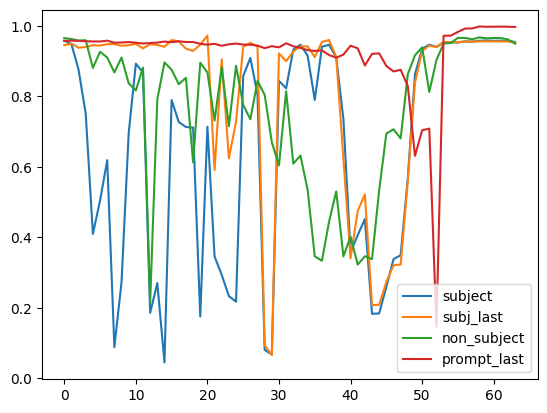

In [27]:
from matplotlib import pyplot as plt

for key in knock_out_results["knock_out_from_last"]:
    plt.plot(knock_out_results["knock_out_from_last"][key], label=key)

plt.legend()

In [28]:
from src.dataset.dataclasses import load_relation
relation = load_relation(file = "../data/relation/factual/place_in_city.json")
relation.select_icl_examples(0)

question, answer = relation[10]
print(question, end="\n\n")
print(f"{answer=}")

2024-03-28 13:15:26 src.dataset.dataclasses INFO     initialized relation -> "place in city" with 154 samples

Parthenon is located in the city of

answer='Nashville'


In [29]:
from src.functional import filter_samples_by_model_knowledge

mt.reset_forward()
relation = filter_samples_by_model_knowledge(
    mt = mt,
    relation = relation,
)

2024-03-28 13:15:27 src.functional DEBUG    "place in city" | filtering with state-spaces/mamba-2.8b
2024-03-28 13:15:27 src.functional DEBUG    sample.subject='Royal Palace of Madrid' -> answer='Madrid' | predicted = ' Madrid'(0.980) ==> (✓)
2024-03-28 13:15:27 src.functional DEBUG    sample.subject='Serengeti National Park' -> answer='Mara Region' | predicted = ' Ar'(0.431) ==> (✗)
2024-03-28 13:15:27 src.functional DEBUG    sample.subject='Vatican Museums' -> answer='Vatican City' | predicted = ' Rome'(0.799) ==> (✗)
2024-03-28 13:15:27 src.functional DEBUG    sample.subject='Moai' -> answer='Easter Island' | predicted = ' H'(0.111) ==> (✗)
2024-03-28 13:15:27 src.functional DEBUG    sample.subject='Canals of Amsterdam' -> answer='Amsterdam' | predicted = ' Amsterdam'(0.963) ==> (✓)
2024-03-28 13:15:27 src.functional DEBUG    sample.subject='Acropolis' -> answer='Athens' | predicted = ' Athens'(0.140) ==> (✓)
2024-03-28 13:15:27 src.functional DEBUG    sample.subject='Alcatraz Islan

In [30]:
knock_out_results = []

for sample in tqdm(relation.samples):
    knock_out_results.append(   
        retention_knockout_on_single_fact(
            mt = mt,
            subject = sample.subject,
            prompt_template = relation.prompt_templates[0],
        )
    )

  0%|          | 0/98 [00:00<?, ?it/s]

2024-03-28 13:15:39 __main__ DEBUG    Subject range: (1, 5)


2024-03-28 13:15:39 __main__ INFO     Royal Palace of Madrid ->  Madrid (0.9800955057144165)
2024-03-28 13:15:46 __main__ INFO     subject -> [0.9738291501998901, 0.8837276697158813, 0.9022238850593567, 0.9134743213653564, 0.9273458123207092, 0.9628821611404419, 0.97480708360672, 0.9828974604606628, 0.9850038290023804, 0.987682044506073, 0.9766885638237, 0.9195742011070251, 0.8801901340484619, 0.86409592628479, 0.9459342360496521, 0.9582145810127258, 0.9442680478096008, 0.949013352394104, 0.9234305024147034, 0.9554877281188965, 0.9545923471450806, 0.8720753788948059, 0.8564096689224243, 0.8872276544570923, 0.824418306350708, 0.9065536260604858, 0.9224874377250671, 0.9157568216323853, 0.5205031037330627, 0.4646463990211487, 0.9653275012969971, 0.8844705820083618, 0.9100160598754883, 0.8648512959480286, 0.854999840259552, 0.8589708805084229, 0.8819771409034729, 0.8305156826972961, 0.7959813475608826, 0.9223600029945374, 0.6026266813278198, 0.6678394079208374, 0.7074168920516968, 0.190308

KeyboardInterrupt: 

2024-03-28 13:22:09 matplotlib.font_manager DEBUG    findfont: Matching Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=16.0.
2024-03-28 13:22:09 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-03-28 13:22:09 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-03-28 13:22:09 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf

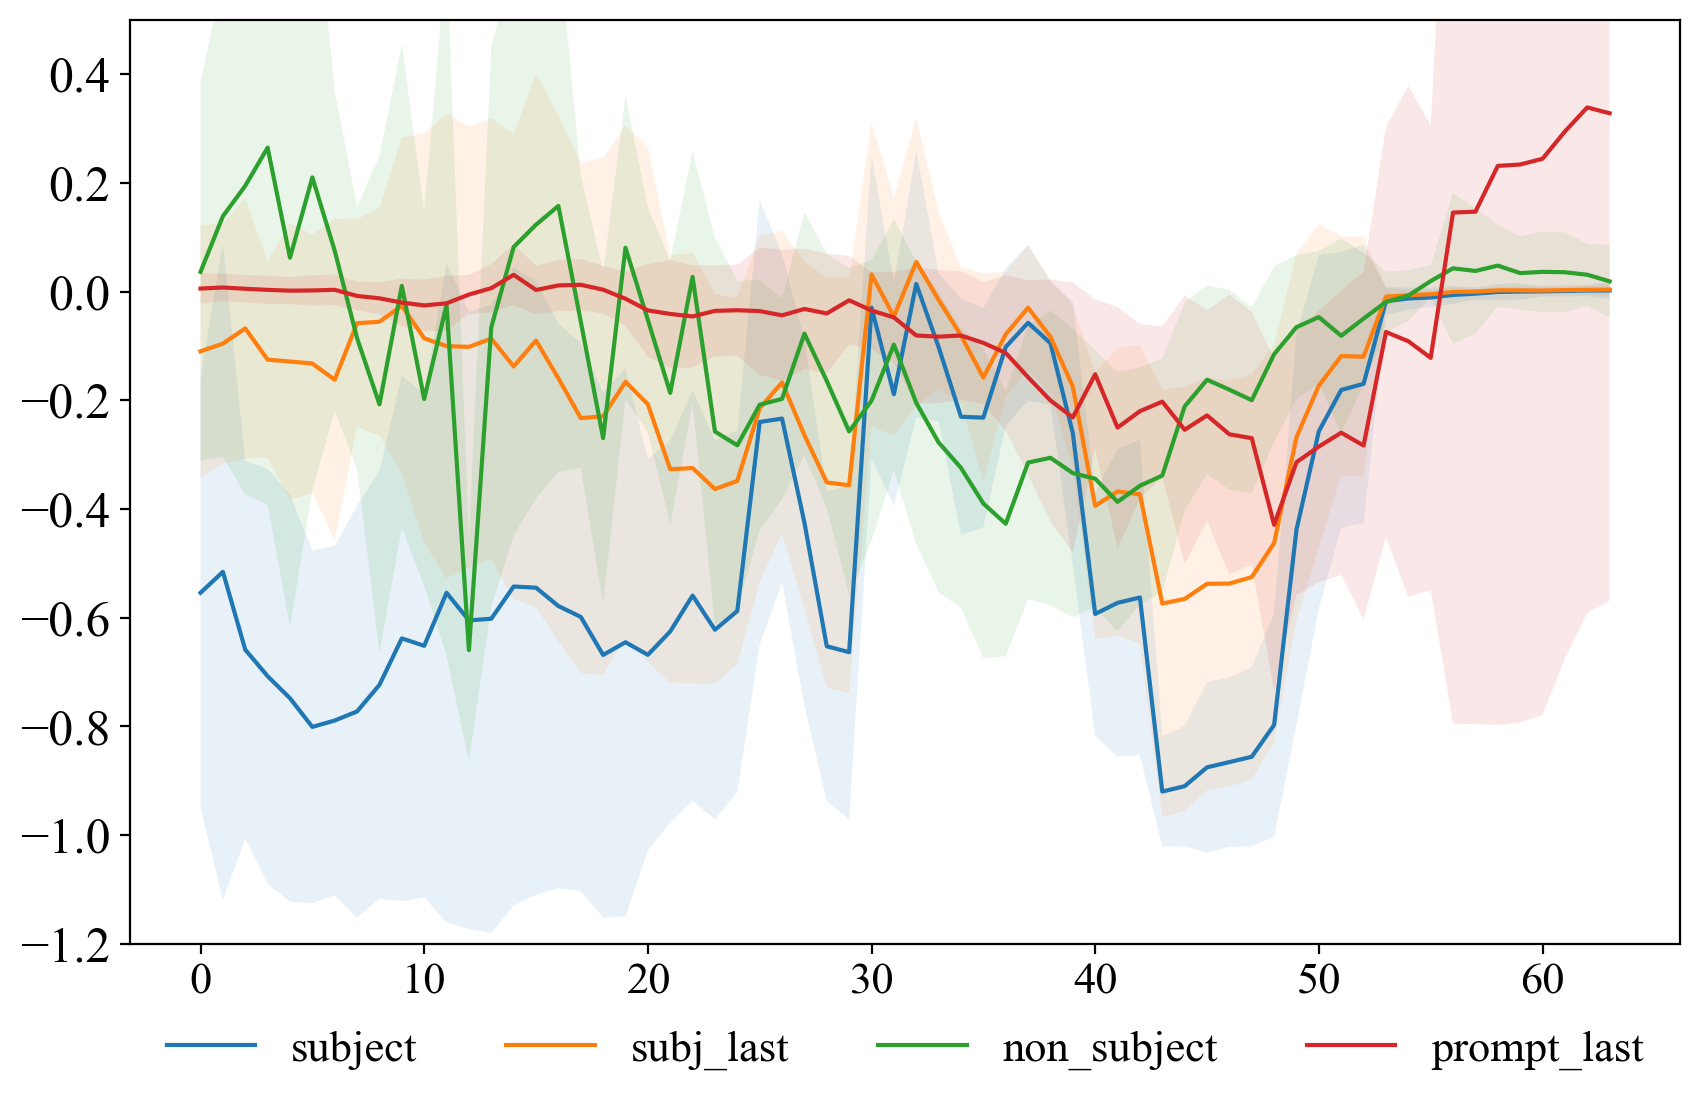

In [31]:
processed_results = {k: [] for k in knock_out_results[0]["knock_out_from_last"].keys()}

for result in knock_out_results:
    p_ans = result["p_answer"]
    for k, v in result["knock_out_from_last"].items():
        relative_change = (torch.Tensor(v) - p_ans) / p_ans
        processed_results[k].append(relative_change)


#####################################################################################
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
# plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
#####################################################################################

plt.figure(figsize=(10, 6))

for k, v in processed_results.items():
    mean = torch.stack(v).mean(dim=0)
    std = torch.stack(v).std(dim=0)

    plt.plot(mean, label=k)
    plt.fill_between(
        range(len(mean)),
        mean - std,
        mean + std,
        alpha=0.1,
    )

plt.ylim(-1.2, 0.5)
plt.legend(ncol = 4, bbox_to_anchor=(0.5, -.18), loc='lower center', frameon=False)
plt.show()

In [32]:
with open("../results/retention_knockout_results.json", "w") as f:
    json.dump(knock_out_results, f)